(2, 20)


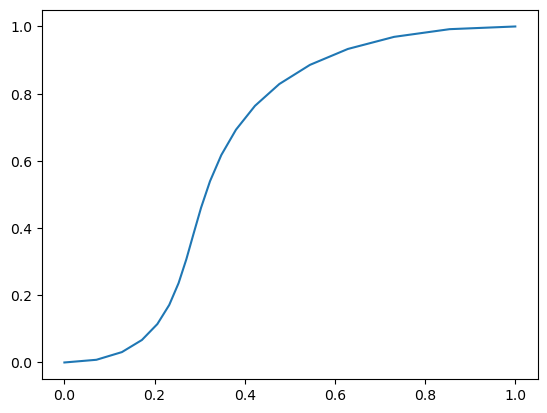

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def bezier(p1, p2, p3, p4, t):
    return (1 - t)**3 * p1 + 3*(1 - t)**2 * t * p2 + 3 * (1 - t) * t**2 * p3 + t**3 * p4

p1 = np.array([0,0])
p2 = np.array([0.5,0])
p3 = np.array([0,1])
p4 = np.array([1,1])

b = bezier(p1, p2, p3, p4, np.linspace([0,0], [1,1], 20)).T

n = 20

bezier_fn = lambda t: (1 - t)**3 * np.array([0,0]) + 3*(1 - t)**2 * t * p2 + 3 * (1 - t) * t**2 * p3 + t**3 * np.array([1,1])
curve = bezier_fn(np.linspace([0,0], [1,1], n)).T

print(curve.shape)

plt.plot(curve[0], curve[1])

None


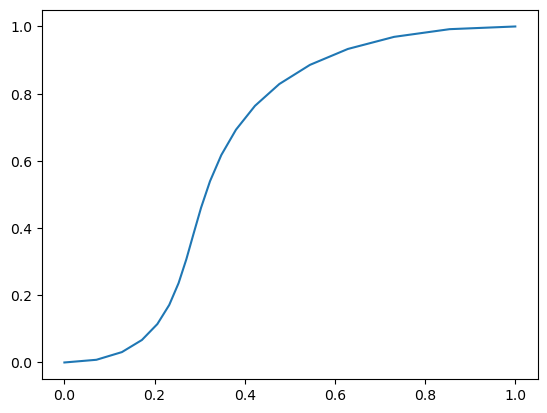

In [2]:
def interpolate_for(x):
    if x == 0:
        return 0
    for i in range(len(curve[0])):
        if x <= curve[0][i]:
            diff = curve[0, i] - curve[0, i - 1]
            prog = x - curve[0, i - 1]
            scal = prog / diff
            return curve[1, i - 1] + (curve[1, i] - curve[1, i - 1]) * scal


plt.plot(curve[0], curve[1])

test_x = 1.1
plt.scatter([test_x] ,[interpolate_for(test_x)])
print(interpolate_for(test_x))

[1.  1.2 1.4 1.6 1.8 2.  2.2 2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2
 4.4 4.6 4.8 5. ]


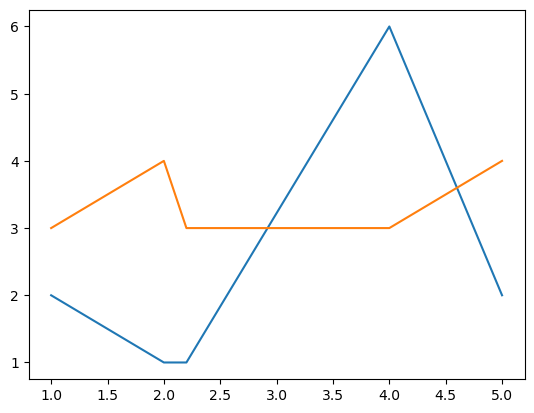

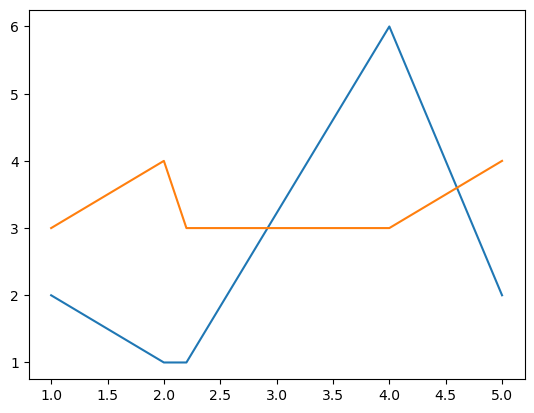

In [3]:
import copy

class TestClass:

    def __init__(self):
        self.times = np.array([1.0, 2.0, 2.2, 4.0, 5.0])
        self.positions = np.array([[2.0, 3.0], [1.0, 4.0], [1.0, 3.0], [6.0, 3.0], [2.0, 4.0]])
    
    def get_position_at(self, timestamp, original=False):
        """
        Interpolates and returns the point at the specified timestamp (in seconds).
        If original is True, use the original trajectory instead of the modified one.
        """

        # initialize timestamp and position variables

        # timestamps to interpolate between
        ts0 = 0.0
        ts1 = 0.0

        # positions to interpolate between
        pos0 = np.zeros((3))
        pos1 = np.zeros((3))

        # choose positions and times arrays based on parameter
        positions = self.true_positions if original else self.positions
        times = self.true_times if original else self.times

        # now interpolate:
        # if the first timestamp is > 0.0, interpolate from 0!
        if timestamp < times[0]:
            ts1 = times[0]
            pos0 = np.zeros((len(positions[0])))
            pos1 = positions[0]
        
        # if the last timestamp is over, remain in end position and set done = True
        elif timestamp > times[len(times) - 1]:
            self.done = True
            return positions[len(positions) - 1]
        
        # otherwise find the two timestamps that the current time is between
        else:
            for i in range (len(times)):
                if times[i] >= timestamp:
                    ts0 = times[i - 1]
                    ts1 = times[i]
                    pos0 = positions[i - 1]
                    pos1 = positions[i]
                    break
        
        # interpolate time
        diff_points = ts1 - ts0
        prog = timestamp - ts0
        scalar = prog / diff_points

        # interpolate position
        return pos0 + (pos1 - pos0) * scalar
    
    def fill_up(self, frequency):
        """
        Fills up the times and positions arrays with interpolated values so that the
        resulting times are filled with a frequency of >frequency per second.
        """
        new_positions = copy.deepcopy(self.positions)
        new_times = copy.deepcopy(self.times)

        # go through every intervall and check if it satisfies the rate
        added = 0

        for i in range(len(self.times) - 1):

            intervall = self.times[i + 1] - self.times[i]

            # if the intervall between these two timestamps it too big, it doesn't satisfy the rate
            # that means new keyframes need to be inserted.
            if intervall > 1/frequency:
                
                j_idx = 0
                added_now = 0
                while (j_idx + 1) * 1/frequency < intervall:
                    new_times = np.insert(new_times, i + j_idx + added + 1, self.times[i] + 1/frequency * (j_idx + 1))
                    new_positions = np.insert(new_positions, i + j_idx + added + 1, self.get_position_at(new_times[i+j_idx + added + 1]), axis=0)
                    j_idx += 1
                    added_now += 1
                added += added_now
        
        #print(new_times.shape, new_positions)

        plt.figure()
        #plt.plot(self.times, self.positions.T[0] + np.sin(self.times) * 3)
        plt.plot(self.times, self.positions)

        plt.figure()
        #plt.plot(new_times, new_positions.T[0] + np.sin(new_times) * 3)
        plt.plot(new_times, new_positions)
        print(new_times)

test = TestClass()
test.fill_up(5)

In [31]:
import os, json

animation_path = r"D:\Users\Marvmul\Documents\01 Studium\Bachelor-Arbeit\Experiments\.txt"
file = None
try:
    file = open(os.path.join(os.getcwd(), animation_path), "r")
except:
    print("ERROR: File " + os.path.join(os.getcwd(), animation_path) + " could not be opened.")

# read file and compute times and joint goals
times = []
positions = []
beziers = []

for line in file:
    # every line has the following structure:
    #  <joint positions> # <timestamp> # <control point 1> # <control point 2>
    parts = line.split("#")
    assert(len(parts) == 4)

    # read parts
    positions.append(json.loads(parts[0]))
    times.append(float(parts[1]))
    beziers.append([json.loads(parts[2]), json.loads(parts[3])])

# apply to trajectory planner
#trajectory_planner = TrajectoryPlanner(np.array(times), np.array(positions))

# fill up to make bezier curves possible
#original_indices = self.trajectory_planner.fill_up(20)

times = np.array(times)
positions = np.array(positions)

# finally close file
file.close()

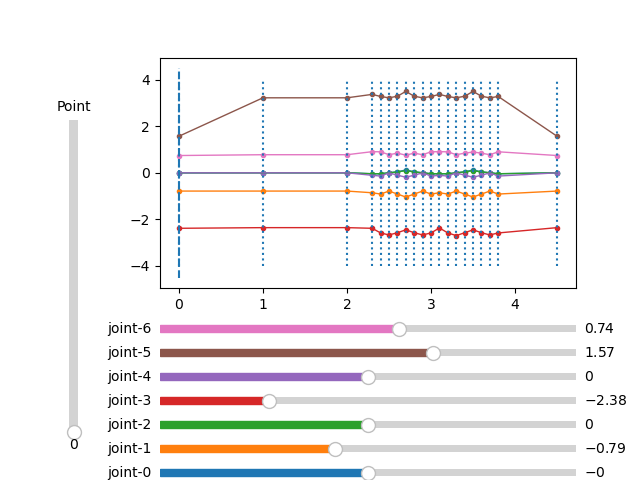

In [32]:
from matplotlib.widgets import Button, Slider

%matplotlib widget
plt.ion()

fig, ax = plt.subplots()
lines = []
for i in range(len(positions.T)):
    l, = ax.plot(times, positions.T[i], linewidth=1)
    lines.append(l)
    ax.scatter(times, positions.T[i], marker=".")

def update(val):
    for i in range(len(positions.T)):
        positions[point_slider.val][i] = joint_sliders[i].val
        lines[i].set_ydata(positions.T[i])

joint_sliders = []
for i in range(len(positions.T)):
    axe = fig.add_axes([0.25, 0.05 * i, 0.65, 0.03])
    joint_sliders.append(Slider(ax=axe, label="joint-" + str(i), valmin=-5, valmax = 5, valinit=positions[0][i], color=lines[i].get_color()))
    joint_sliders[i].on_changed(update)


axe_point = fig.add_axes([0.1, 0.1, 0.03, 0.65])
point_slider = Slider(ax=axe_point, label="Point", valstep=range(len(positions)), valinit=0, valmin=0, valmax=len(positions), orientation='vertical')

vlines = ax.vlines(times, -4, 4, linestyles="dotted")
indicator = ax.vlines(times[0], -4.5, 4.5, linestyles="dashed")

def update_point(val):
    global indicator
    for i in range(len(positions.T)):
        joint_sliders[i].eventson = False
        joint_sliders[i].set_val(positions[point_slider.val][i])
        #fig.canvas.draw()
        joint_sliders[i].eventson = True
        lines[i].set_ydata(positions.T[i])
    #indicator.set_array(times[val])
    indicator.remove()
    indicator = ax.vlines(times[val], -4.5, 4.5, linestyles="dashed")

point_slider.on_changed(update_point)


fig.subplots_adjust(left=0.25, bottom=0.4)


plt.show()

In [20]:
# write back to file!
file = open(r"D:\Users\Marvmul\Documents\01 Studium\Bachelor-Arbeit\Experiments\happy2.txt", mode='w')

for i in range(len(positions)):
    print(positions[i].tolist(), file=file, end="#")
    print(times[i], file=file, end='#')
    print(beziers[i][0], file=file, end='#')
    print(beziers[i][1], file=file, end='\n')

file.close()

In [34]:
# NEW SAVING WAY
file = open(r"D:\Users\Marvmul\Documents\01 Studium\Bachelor-Arbeit\Experiments\happy_alt.txt", mode='w')

# first, write positions
for i in range(len(positions)):
    print(times[i], file=file, end='#')
    print(positions[i].tolist(), file=file, end="\n")

# then, write beziers
print("CURVES", file=file)

for i in range(len(beziers)):
    print(i, ":", i + 1, sep="", end="#", file=file)
    print(beziers[i][0], file=file, end="#")
    print(beziers[i][1], file=file, end='\n')

file.close()